# Chasing the power of optimal length increase

(c) 2021 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [3]:
using CSV, DataFrames, Distributed, Dates, LinearAlgebra, Distributions, DelimitedFiles, SharedArrays, Plots
# Custom package
using Jevo, Jedi

# Set plotting style
Jedi.default_gr!()

┌ Info: Precompiling Jedi [b681c197-c997-42fd-b5bb-d7d7839f617e]
└ @ Base loading.jl:1278
┌ Warning: Package Jedi does not have Measures in its dependencies:
│ - If you have Jedi checked out for development and have
│   added Measures as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Jedi
└ Loading Measures into Jedi from project dependency, future warnings for Jedi are suppressed.


Plots.GRBackend()

## 1. Full Gamma Dynamics

First, let's have a look at the full $\Gamma$ dynamics. Therefore, we use the Kimura substitution probability to compute a distribution. Let's write down the rates for a match turning into a mismatch, $u_+(\Gamma, l)$, and the rate for a mismatch turning into a match, $u_-(\Gamma, l)$,

\begin{align}
u_+(\Gamma) &= \left(1 - \frac{\Gamma}{\epsilon l}\right) \left[p(F(\Gamma + \epsilon, l) - F(\Gamma, l) +\frac{\kappa}{N}\right],\\
u_-(\Gamma) &= \frac{\Gamma}{\epsilon l}\frac{1}{1-n} \left[p(F(\Gamma - \epsilon, l) - F(\Gamma, l) +\frac{\kappa}{N}\right],
\end{align}

where $p(s)$ is the Kimura substitution probability. The prefactors determine the probability of a match/mismatch mutating, which depends on the current state of the population. The extra prefactor $\frac{1}{1-n}$ comes from the consideration that a mismatch can mutate to another mismatch, which is not detectable on the level of quantitative traits. A similar factor is absent from the rate turning a match into am mismatch, since every mutation on a match leads to a mismatch. 

Then we use these rates to determine the probability distribution over the binding energies,

$$
Q(\Gamma, l) \propto \prod_{\Gamma^\prime=\epsilon}^\Gamma \frac{u_+(\Gamma-\epsilon, l)}{u_-(\Gamma, l)}.
$$

It might be more useful to compute the free fitness $\Psi$ instead, which is simply the log of the distribution,

$$
\Psi(\Gamma, l) \propto \sum_{\Gamma^\prime=\epsilon}^\Gamma \log\left[\frac{u_+(\Gamma-\epsilon, l)}{u_-(\Gamma, l)}\right].
$$

In [38]:
# Neutral Expectation
γ_0(n) = (n-1)/n

# Binding Threshold
γ_1(l, n, l_0) = γ_0(n) - l_0/l

# Binding probability
pb(γ, l, n, l_0, gap) = 1 / (1 + exp(gap * (l / l_0) * (γ - γ_1(l, n, l_0))))

# Fitness component for functional binding
F_b(γ, l, n, l_0, gap, f0) = f0 * pb(γ, l, n, l_0, gap)

# Fitness component of genomic constraint
F_c(l, l_0, fl) = - fl * l / l_0

# Total Fitness
F(γ, l, n, l_0, gap, f0, fl) = F_b(γ, l, n, l_0, gap, f0) + F_c(l, l_0, fl)

function kimura(s)
    if s^2 < 10^(-20)
        return 1
    elseif s < -10^7
        return 0
    else
        return s/(1 - exp(-s))
    end
end

# Substitution rate for trait changes
# (k, l) -> (k + 1, l)
up(γ, l, n, l_0, gap, f0, fl, κ) =  (1 - γ) * (kimura(F(γ + 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# (k, l) -> (k - 1, l)
um(γ, l, n, l_0, gap, f0, fl, κ) = γ * (1 - (n-2)/(n-1)) * (kimura(F(γ - 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# Free Fitness
function Ψ(l, n, l_0, gap, f0, fl, κ)
    # Start at neutral γ
    γ_i = floor(γ_0(n) * l) / l
    return collect(0:1/l:γ_i), push!(Float64[0], cumsum([log(up(γ - 1/l, l,  n, l_0, gap, f0, fl, κ) / um(γ, l,  n, l_0, gap, f0, fl, κ)) for γ in 1/l:1/l:γ_i])...)
    
end

# (k,l) -> (k+1,l+1)
γ_pp(γ, l) = min((γ + 1/l)/(1 + 1/l), 1)

# (k,l) -> (k,l+1)
γ_pm(γ, l) = max(γ /(1 + 1/l), 0)

# (k,l) -> (k,l-1)
γ_mp(γ, l) = min(γ/(1 - 1/l), 1)

# (k,l) -> (k-1,l-1)
γ_mm(γ, l) = max((γ - 1/l)/(1 - 1/l), 0)


# selection coeffcients for length increase and decrease
# (k,l) -> (k+1,l+1)
s_pp(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pp(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

# (k,l) -> (k,l+1)
s_pm(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pm(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

# (k,l) -> (k-1,l-1)
s_mm(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mm(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl) 

# (k,l) -> (k,l-1)
s_mp(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mp(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl)

s_mp (generic function with 1 method)

Let's compare this theoretical prediction with some numerics. Therefore we first determine some parameters.

In [40]:
gap = 10
l_0 = 20
f0 = 40l_0
n = 4
N = 100

# Iniate Fitness landscape
F_th = Jevo.num_fermi(n, l_0, gap, f0,0)
F_num = Jevo.num_fermi(n, l_0, gap, f0/2N,0)

emat = gap/l_0 * (ones(n, n) - Matrix{Float64}(I, n, n))

4×4 Array{Float64,2}:
 0.0  0.5  0.5  0.5
 0.5  0.0  0.5  0.5
 0.5  0.5  0.0  0.5
 0.5  0.5  0.5  0.0

This is the classic simulation code for substitution dynamics with fixed lengths and driver mutations.

In [8]:
# Run one rep
function Run(N, l, emat, F, κ, l_0, gap, steps)
    E_arr = zeros(Float64, steps)
    pop = Jevo.mono_pop(N=N, l=l)
    Jevo.initiate!(pop, emat)
    for r in 1:steps
        Jevo.bp_substitution!(pop, emat, F)
        if rand() < κ/N
            Jevo.driver_mutation!(pop)
        end
        E_arr[r] = Jevo.get_energy(pop, emat)
    end
    return E_arr
end

Run (generic function with 1 method)

A quick custom function to make a histogram, since we have discrete values and don't rely on binning.

In [9]:
function make_histogram(data)
    x = sort(unique(data))
    y = [sum(data .== t) for t in x]
    return x, y
end

make_histogram (generic function with 1 method)

Let's run a bunch of driving rates for some lengths.

In [11]:
function run_batch(κ, first_data=5000, steps=2*10^5)
    x, y = [], []
    for l in 40:1:200
        E = Run(N, l, emat, F_num, κ, l_0, gap, steps)
        _x, _y = make_histogram(E[first_data:end])
        push!(x, _x)
        push!(y, _y)
    end
    return x, y
end

run_batch (generic function with 3 methods)

In [18]:
κ_arr = collect(0:5:10)
x_fix_list = []
y_fix_list = []
for κ in κ_arr
    x, y = run_batch(κ)
    push!(x_fix_list, x)
    push!(y_fix_list, y)
    println("κ = $κ done.")
end

κ = 0 done.
κ = 5 done.
κ = 10 done.


I think it is more convenient to store the results in a dictionary.

In [19]:
fix_dict = Dict([x=>(y1,y2) for (x, y1, y2) in zip(κ_arr, x_fix_list, y_fix_list)]);

A quick and dirty graphical check is to simply look at many distributions at the same time. 

In [20]:
# Probability distribution (from free Fitness)
function Q(l, n, l_0, gap, f0, fl, κ)
    x, y = Ψ(l, n, l_0, gap, f0, fl, κ)
    return x, exp.(y)
end



Q (generic function with 1 method)

In [27]:
function plot_all_dists(κ)
    p_list = []
    for (i, l) in zip(1:10:161, 40:10:200)
        x_t, theory = Q(l, n, l_0, gap, F_th.f0, F_th.fl, κ)
        x_t = x_t .* (l *gap/l_0)
        theory = theory/ sum(theory)
        x, y = fix_dict[κ]
        p = plot(x_t, theory, title=l, xlims=[minimum(x[i]), maximum(x[i])])
        scatter!(twinx(), x[i], y[i] ./ sum(y[i]), xlims=[minimum(x[i]), maximum(x[i])])#, xlims=[minimum(x[i]), maximum(x[i])])
        #plot!(twinx(), x_t, Jevo.fitness.(x_t, l, F), color="orange", xlims=[minimum(x[i]), maximum(x[i])], ylims=([0.9, 1.] .* F.f0 .+ F.fl/l_0 *l))
        push!(p_list, p)
    end
    return plot(p_list..., size=(1000, 1000))
end

plot_all_dists (generic function with 1 method)

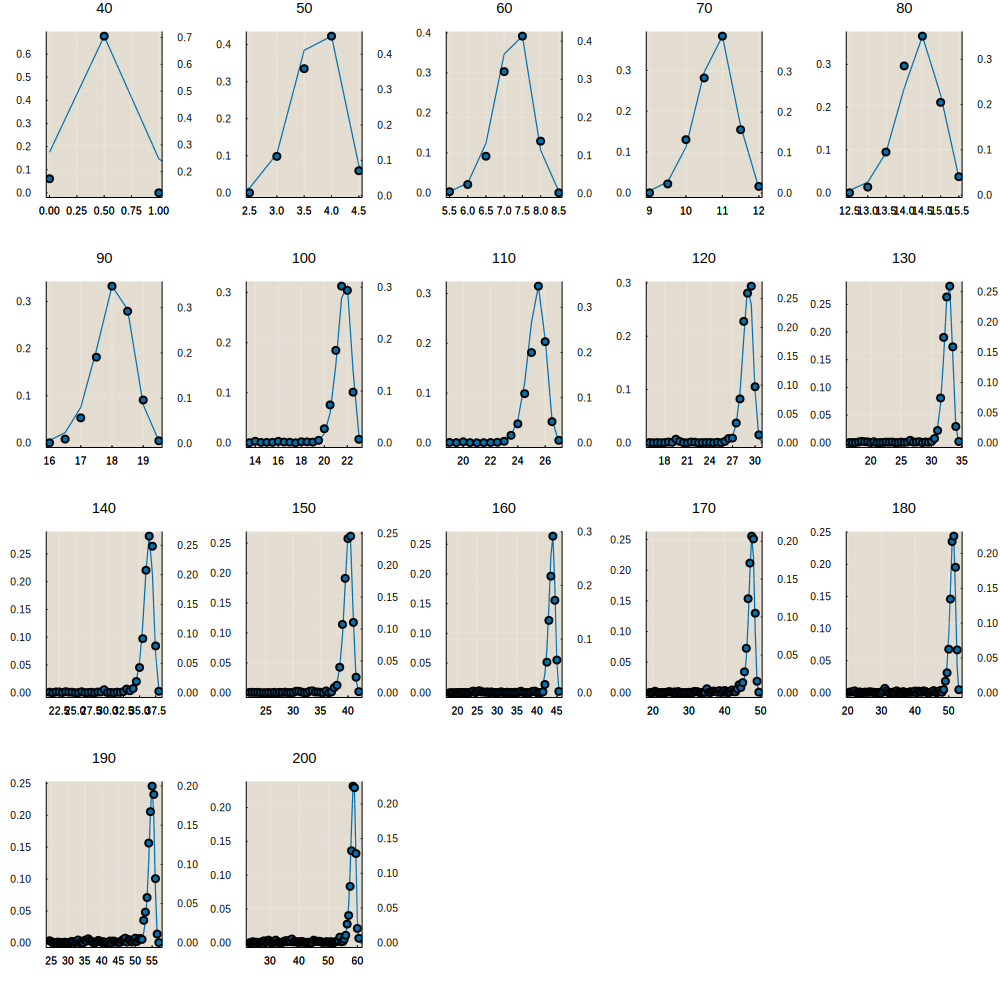

In [28]:
plot_all_dists(0)

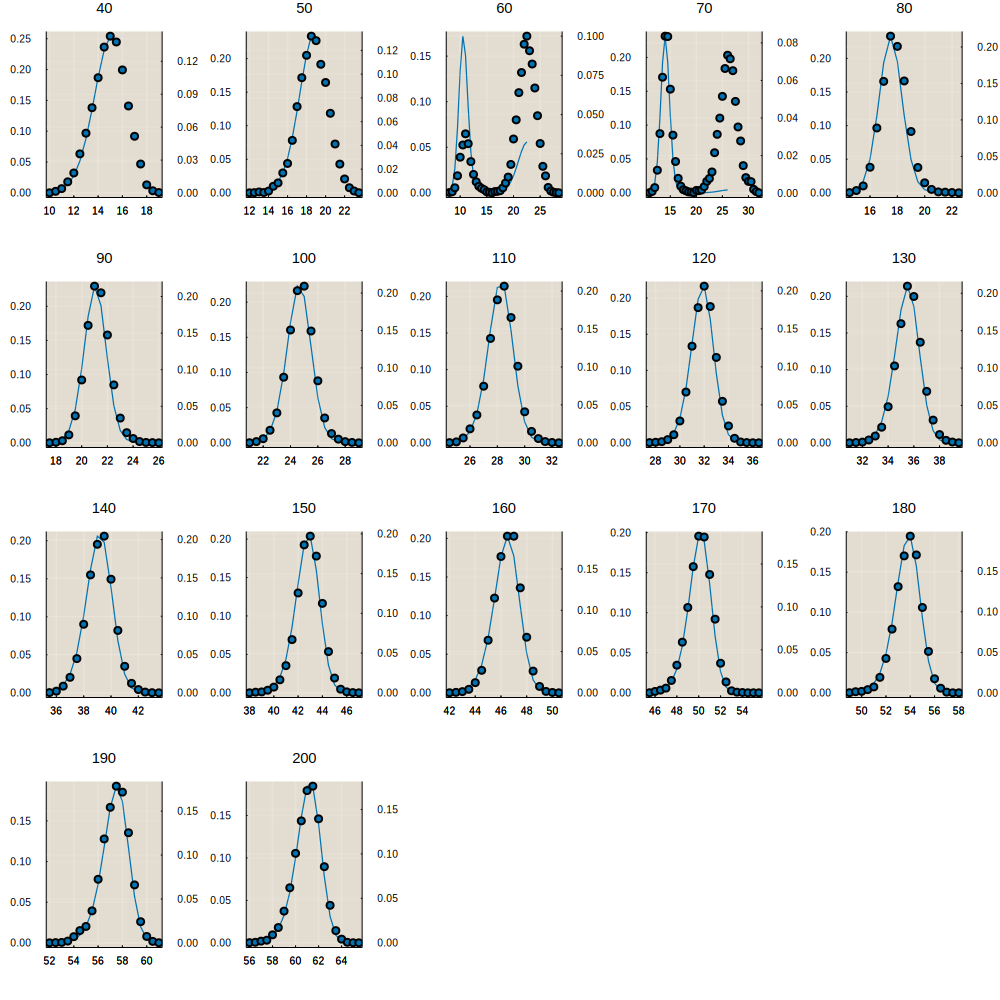

In [29]:
plot_all_dists(10)

Now we want to use these distributions to compute the optimal length. 

In [47]:
function kimura(s::Real)
    if abs(s) <= 10^-20
        return 1 / N
    elseif s < -10^6
        return 0
    else
        return s / (1 - exp(-s))
    end
end

kimura (generic function with 3 methods)

In [48]:
function p_l_th(κ, n, l_0, gap, f0, fl, l_range=collect(40:200))
    vp = []
    vm = []
    for l in l_range
        x, y = Q(l, n, l_0, gap, f0, fl, κ)
        y = y/sum(y)
        s_mm_p = [s_pp(γ, l, n, l_0, gap, f0, fl) for γ in x]
        s_m_p = [s_pm(γ, l, n, l_0, gap, f0, fl) for γ in x]
        s_mm_m = [s_mm(γ, l, n, l_0, gap, f0, fl) for γ in x]
        s_m_m = [s_mp(γ, l, n, l_0, gap, f0, fl) for γ in x]
        v_mm_p = [(n-1)/n * kimura(s) for s in s_mm_p]
        v_m_p = [1/n * kimura(s) for s in s_m_p]
        v_mm_m = [ γ * kimura(s) for (s, γ) in zip(s_mm_m, x)]
        v_m_m = [(1 - γ)  * kimura(s) for (s, γ) in zip(s_m_m, x)]
        push!(vp, sum((v_m_p .+ v_mm_p) .* y))
        push!(vm, sum((v_mm_m .+ v_m_m) .* y))
    end
    return vp, vm, push!([0.01], (cumsum([log(vp[i]/vm[i+1]) for i in 1:length(vp)-1]).+0.01)...)
end

p_l_th (generic function with 2 methods)

In [32]:
function p_l_sim(κ)
    vp = []
    vm = []
    x, y = fix_dict[κ]
    for (i, l) in enumerate(40:200)
        _x = x[i]
        _y = y[i]
        _y = _y/sum(_y)
        s_mm_p = [Jevo.fitness((k+gap/l_0), l+1, F) - Jevo.fitness(k, l, F) for k in _x]
        s_m_p = [Jevo.fitness(k, l+1, F) - Jevo.fitness(k, l, F) for k in _x]
        s_mm_m = [ k > 0 ? Jevo.fitness(k-gap/l_0, l-1, F) - Jevo.fitness(k, l, F) : -10^8 for k in _x]
        s_m_m = [Jevo.fitness(k , l-1, F) - Jevo.fitness(k, l, F) for k in _x]
        v_mm_p = [(n-1)/n * kimura(s, N) for s in s_mm_p]
        v_m_p = [1/n * kimura(s, N) for s in s_m_p]
        v_mm_m = [ k * l_0/gap /l * kimura(s, N) for (s, k) in zip(s_mm_m, _x)]
        v_m_m = [(1 - (k * l_0/gap /l))  * kimura(s, N) for (s, k) in zip(s_m_m, _x)]
        push!(vp, sum((v_m_p .+ v_mm_p) .* _y))
        push!(vm, sum((v_mm_m .+ v_m_m) .* _y))
    end
    return push!([0.01], (cumsum([log(vp[i]/vm[i+1]) for i in 1:length(vp)-1]).+0.01)...)
end

p_l_sim (generic function with 1 method)

In [49]:
x_κ = collect(0:0.5:20)
l_opt_sim = []
l_opt_theory = []
for κ in x_κ
    push!(l_opt_theory, argmax(p_l_th(κ, n, l_0, gap, F_th.f0, F_th.fl)) + 39)
    #push!(l_opt_sim, argmax(p_l_sim(κ)) + 39)
end

plot(x_κ, l_opt_theory)
#plot!(x_κ, l_opt_sim) 
l_opt_theory

41-element Array{Any,1}:
 40
 40
 40
 40
 40
 40
 40
 40
 40
 40
 40
 40
 40
  ⋮
 40
 40
 40
 40
 40
 40
 40
 40
 40
 40
 40
 40

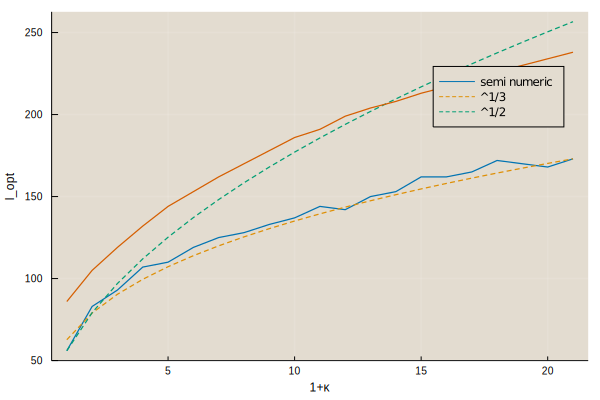

In [101]:
x = κ_arr[1:end] .+ 1
l_max_theory = argmax.(p_l_list[1:end]).+39
l_max_plot = plot(x, l_max_theory, label="semi numeric")
plot!(l_max_plot, x, x .^ (1/3) /(21)^(1/3)*l_max_theory[end], linestyle=:dash, label="^1/3")
plot!(l_max_plot, x, x .^ (1/2) * l_max_theory[1], linestyle=:dash, label="^1/2")
plot!(l_max_plot, xlabel="1+κ", ylabel="l_opt")
plot!(l_max_plot, xxx.+1, yy)


In [41]:
x_max100 = []
for (l, κ) in zip(l_max_theory, collect(0:0.5:10))
    E = Run(N, l, emat, F, κ, l_0, gap, 10^5)
    x, y = make_histogram(E[5000:end])
    push!(x_max100, x[argmax(y)]/l*2)
end

plot(log.(collect(0:0.5:10) .+1), log.(x_max100))
plot!(log.(1 .+ collect(0:0.5:10)), log.((collect(0:0.5:10).+1).^(1/6) .* x_max100[end]/10^(1/6)))
plot!(log.(1 .+ collect(0:0.5:10)), log.((collect(0:0.5:10).+1).^(1) .* x_max100[1]))

LoadError: UndefVarError: l_max_theory not defined

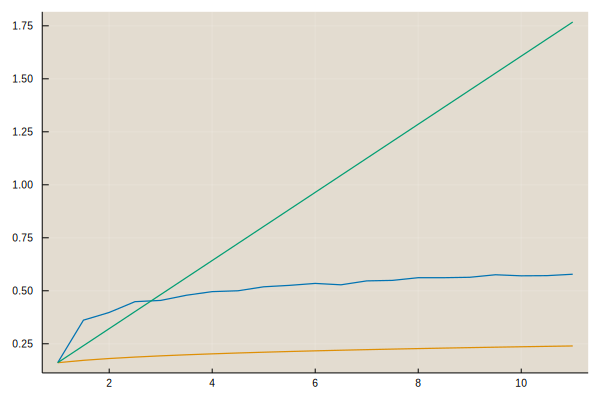

In [117]:
plot(collect(0:0.5:10) .+1, x_max100)
plot!(1 .+ collect(0:0.5:10), (collect(0:0.5:10).+1).^(1/6) .* x_max100[1])
plot!(1 .+ collect(0:0.5:10), (collect(0:0.5:10).+1).^(1) .* x_max100[1])

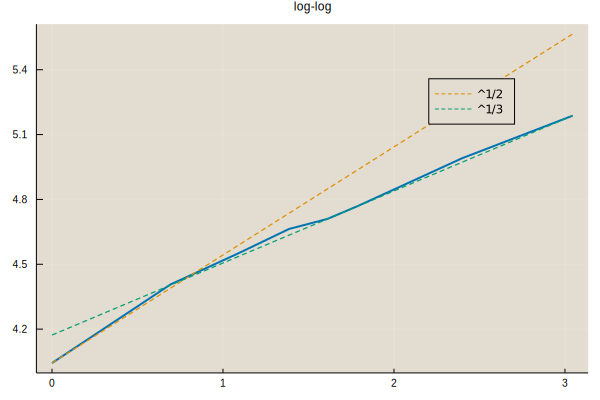

In [73]:
plot(log.(x), log.(l_max_theory), linewidth=2, title="log-log")
plot!(log.(x), log.(x .^ (1/2) * l_max_theory[1]), linestyle=:dash, label="^1/2")
plot!(log.(x), log.(x .^ (1/3) /(21)^(1/3)*l_max_theory[end]), linestyle=:dash, label="^1/3")

### Dynamic L

In [45]:
K(x, x_arr, y_arr, h) = 1/sum(y_arr)/h * sum([exp(-1/2*((x - x_arr[i])/h)^2) * y_arr[i] for i in eachindex(x_arr)])

K (generic function with 1 method)

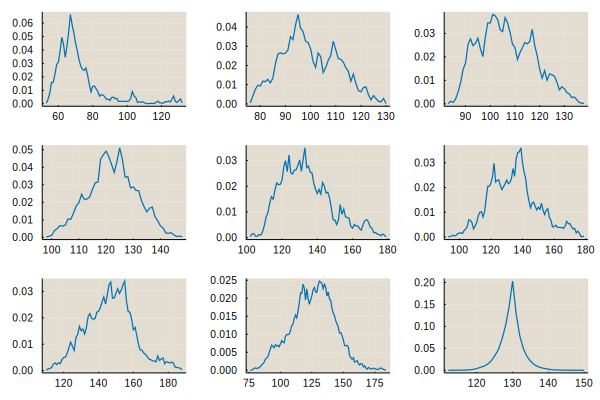

In [46]:
df = CSV.read("../outputs/2021_02_06_results.csv", DataFrame)
p_list = []
lmax = []
for _df in groupby(df, "kappa")
    y_plot = [K(x, _df.l, _df.p_l, 1) for x in _df.l]
    push!(p_list, plot(_df.l, _df.p_l))
    push!(lmax, _df.l[argmax(y_plot)])
end
plot(p_list...)

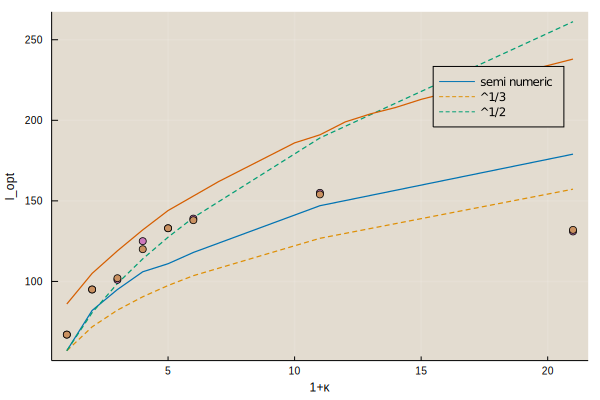

In [47]:
scatter!(l_max_plot, κ_arr[1:end-1] .+ 1, lmax[1:end-1], xlabel="1+κ", ylabel="l_opt")